## Descrição do problema

Os cartões de crédito são utilizados na indústria financeira para prever a probabilidade de inadimplência e orientar a emissão de cartões de crédito. Esses scores de crédito dependem dos dados pessoais dos candidatos e de informações históricas, quantificando o risco de maneira objetiva.

Este projeto tem como objetivo criar um modelo de Classificador de Floresta Aleatória (Random Forest) para ajudar os bancos a decidir quem deve receber um cartão de crédito.

## Carregando Bibliotecas

In [1]:
# Carregando bibliotecas
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score

## Descrição das colunas do conjuto de dados "application record"

| Nome do recurso          | Explicação                          | Observações                                                                 |
|--------------------------|-------------------------------------|-----------------------------------------------------------------------------|
| ID                       | Número do cliente                   |                                                                             |
| CODE_GENDER              | Gênero                              |                                                                             |
| FLAG_OWN_CAR             | Tem um carro                        |                                                                             |
| FLAG_OWN_REALTY          | Existe uma propriedade              |                                                                             |
| CNT_CHILDREN             | Número de crianças                  |                                                                             |
| AMT_INCOME_TOTAL         | Renda anual                         |                                                                             |
| NAME_INCOME_TYPE         | Categoria de renda                  |                                                                             |
| NAME_EDUCATION_TYPE      | Nível de educação                   |                                                                             |
| NAME_FAMILY_STATUS       | Estado civil                        |                                                                             |
| NAME_HOUSING_TYPE        | Modo de vida                        |                                                                             |
| DAYS_BIRTH               | Aniversário                         | Contagem regressiva a partir do dia atual (0), -1 significa ontem           |
| DAYS_EMPLOYED            | Data de início do emprego           | Contagem regressiva a partir do dia atual (0). Se positivo, significa que a pessoa está atualmente desempregada. |
| FLAG_MOBIL               | Existe um telefone celular?         |                                                                             |
| FLAG_WORK_PHONE          | Existe um telefone de trabalho?     |                                                                             |
| FLAG_PHONE               | Tem algum telefone?                 |                                                                             |
| FLAG_EMAIL               | Existe um e-mail                    |                                                                             |
| OCCUPATION_TYPE          | Ocupação                            |                                                                             |
| CNT_FAM_MEMBERS          | Tamanho da família                  |                                                                             |


# Carregando conjunto de dados application record

In [2]:
# Carregando o conjuto de dados
df_application = pd.read_csv('../data/application_record.csv')

# Pré-visualizando conjunto de dados
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
# Conhecendo o conjuto de dados aplplication record 
print('Visualizando quantidade de linhas do conjunto de dados application record:', df_application.shape[0])

print('Visualizando quantidade de colunas do conjunto de dados application record:', df_application.shape[1])

Visualizando quantidade de linhas do conjunto de dados application record: 438557
Visualizando quantidade de colunas do conjunto de dados application record: 18


In [4]:
# Visualizando tipos de dados
df_application.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

### Observações

* O conjunto de dados application record possuí 438557 linhas e 18 colunas
* O conjunto contém um total de 10 colunas numéricas
* O conjuto contém 8 colunas object

## Descrição das colunas do conjunto de dados "credit record"

| Nome do Recurso   | Explicação  | Observações |
|------------------|------------|-------------|
| ID              | Número do cliente | |
| MONTHS_BALANCE | Mês recorde | O mês dos dados extraídos é o ponto de partida, para trás, 0 é o mês atual, -1 é o mês anterior e assim por diante |
| STATUS         | Status | 0: 1-29 dias em atraso <br> 1: 30-59 dias em atraso <br> 2: 60-89 dias em atraso <br> 3: 90-119 dias em atraso <br> 4: 120-149 dias em atraso <br> 5: Dívidas vencidas ou inadimplentes, amortizações por mais de 150 dias <br> C: Quitadas naquele mês <br> X: Nenhum empréstimo no mês |


# Carregando conjunto de dados credit record

In [5]:
# Carregando conjunto de dados
df_credit = pd.read_csv('../data/credit_record.csv')

# Pré-visualizando conjunto de dados
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
print('Visualizando quantidade de linhas do conjunto de dados credit record:', df_credit.shape[0])

print('Visualizando quantidade de colunas do conjunto de dados credit record:', df_credit.shape[1])

Visualizando quantidade de linhas do conjunto de dados credit record: 1048575
Visualizando quantidade de colunas do conjunto de dados credit record: 3


In [7]:
# Visualizando tipos de dados
df_credit.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

### Observações

* O conjunto de dados credit record possuí 1048575 linhas e 3 colunas
* O conjunto contém um total de 2 colunas numéricas
* O conjuto contém 1 coluna object que mostra o status dos detalhes da cobrança do cartão de credito

# Mesclando ambos os conjuntos de dado(Base de ID comum)

In [8]:
# Mesclando ambos os dataframe com base no ID

df = pd.merge(df_application, df_credit, on='ID', how='inner')

* Mesclei os dois dataframes com base na coluna ID presente em ambos os conjuntos de dados.
* Além disso, o conjunto de dados Credit record tem mais registros de clientes do que o conjunto de dados Application record, então garantimos que nosso novo dataframe df contenha apenas as linhas que têm o mesmo número de ID
* Para esse propósito, usei o parâmetro inner na função pd.merge

In [9]:
# Pré-visualizando o novo conjunto

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [10]:
# verificando a forma do novo dataframe

print('Visualizando quantidade de linhas do novo dataframe:', df.shape[0])
print('Visualizando quantidade de colunas do novo dataframe:', df.shape[1])

Visualizando quantidade de linhas do novo dataframe: 777715
Visualizando quantidade de colunas do novo dataframe: 20


### Observações

* Anteriormente, vi que o conjunto de dados do application record tem 438557 linhas
* Agora o conjunto de dados mesclado contém apenas 777715
* Isso significa que o conjunto de dados do application record e credit record tem apenas 777715 linhas com números de ID comuns

# Verificando valores ausentes e lidando com eles

In [11]:
# Verificando valores nulos

df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

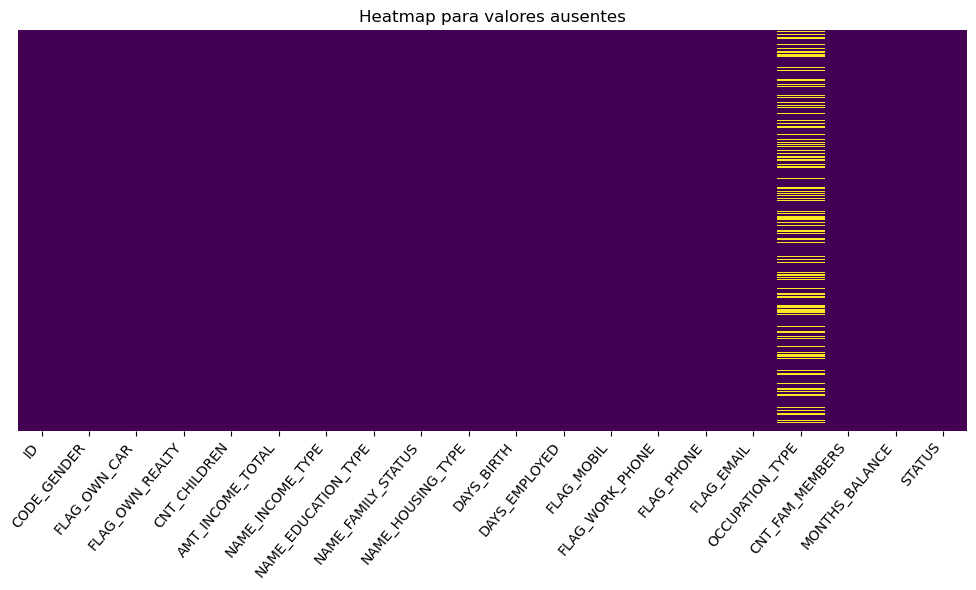

In [12]:
# Definindo tamanho da figura
plt.figure(figsize=(10,6))

# Plotando o mapa de calor para valores ausentes
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

# Definindo o título
plt.title('Heatmap para valores ausentes')

# Ajustando os rótulos do eixo X para espaçamento uniforme
plt.xticks(rotation=50, ha='right')  
plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [13]:
# Checando o percentual de valores ausentes na coluna "OCCUPATION_TYPE"

df['OCCUPATION_TYPE'].isnull().sum()/df.shape[0]*100

np.float64(30.86580559716606)

### Observações

* O dataframe possuí apenas uma coluna com valores ausentes
* A coluna "OCCUPATION_TYPE" possuí um total de 240048 valores ausentes um percentual de 30.86%
* Optarei por remover a coluna OCCUPATION_TYPE do dataframe por possuir um alto percental de valores ausentes e cada pessoa tem seu próprio registro exclusivo. E não posso colocar imputar os valores ausentes com o modo

In [14]:
# Removendo a coluna
df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

# Cofirmando resultado
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

# Checando a quantidade de valores únicos no dataframe 

In [15]:
df.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
CNT_FAM_MEMBERS           10
MONTHS_BALANCE            61
STATUS                     8
dtype: int64

### Observações

* O conjunto de dados possuí um total de 777515 linhas, mas existe apenas 36457 registro únicos na coluna ID
* Isso mostra que o conjunto de dados pode ter algumas duplicatas 

# Verficando duplicatas

In [16]:
# Verificando duplicatas

df.duplicated().sum()

np.int64(0)

In [17]:
df[df['ID'].duplicated()].head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-4,C
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-5,C
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-6,C
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-7,C
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-8,C
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-9,C
10,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-10,C


In [18]:
df[df['ID'].duplicated()].tail(20)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
777694,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-3,0
777695,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-4,0
777696,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-5,0
777697,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-6,0
777698,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-7,0
777699,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-8,0
777700,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-9,0
777702,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-1,0
777703,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-2,0
777704,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-3,0


### Observações

* Após essa verficição com base no número de entrandas únicas na coluna ID constatei que existem 36457 dados de clientes
* E também não há duplicatas no conjunto de dados de 36457 ID que são coletados com base em diferentes meses de MONTHS_BALANCE

# Renomeando colunas

In [19]:
# Verificando colunas
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [20]:
# Renomeando colunas
df.rename(columns={
  'CODE_GENDER' : 'gender',
  'FLAG_OWN_CAR':'owns_car',
  'FLAG_OWN_REALTY' : 'owns_property',
  'CNT_CHILDREN' : 'num_children',
  'AMT_INCOME_TOTAL': 'total_income',
  'NAME_INCOME_TYPE': 'income_type',
  'NAME_EDUCATION_TYPE': 'education_level',
  'NAME_FAMILY_STATUS': 'family_status',
  'NAME_HOUSING_TYPE': 'housing_type' ,
  'DAYS_BIRTH': 'age_in_days',
  'DAYS_EMPLOYED': 'employment_in_days',
  'FLAG_MOBIL': 'mobile',
  'FLAG_WORK_PHONE': 'work_phone',
  'FLAG_PHONE': 'phone',
  'FLAG_EMAIL': 'email',
  'CNT_FAM_MEMBERS': 'family_members',
  'MONTHS_BALANCE': 'months_balance',
  'STATUS': 'status'
}, inplace= True), 

(None,)

In [21]:
df.columns

Index(['ID', 'gender', 'owns_car', 'owns_property', 'num_children',
       'total_income', 'income_type', 'education_level', 'family_status',
       'housing_type', 'age_in_days', 'employment_in_days', 'mobile',
       'work_phone', 'phone', 'email', 'family_members', 'months_balance',
       'status'],
      dtype='object')

In [22]:
# verificando colunas com tipo de object

df.select_dtypes(include='object').columns

Index(['gender', 'owns_car', 'owns_property', 'income_type', 'education_level',
       'family_status', 'housing_type', 'status'],
      dtype='object')

In [23]:
# Verificando valores unicos de algumas colunas

col = ['gender', 'owns_car', 'owns_property']

for i in col:
    print(f'{df[i].value_counts()}')

gender
F    518851
M    258864
Name: count, dtype: int64
owns_car
N    473355
Y    304360
Name: count, dtype: int64
owns_property
Y    512948
N    264767
Name: count, dtype: int64


In [ ]:
# mapeando os valores em algumas colunas

# mapeando entradas únicas de gender, owns_car e owns_property
df['gender'] = df['gender'].map({'F':'female', 'M': 'male'})
df['owns_car'] = df['owns_car'].map({'N': 'no', 'Y': 'yes'})
df['owns_property'] = df['owns_property'].map({'N': 'no', 'Y': 'yes'})

In [25]:
# checando valores únicos na coluna status

df['status'].value_counts()

status
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64